##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Customize what happens in Model.fit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/customizing_what_happens_in_fit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/guides/customizing_what_happens_in_fit.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/keras/customizing_what_happens_in_fit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

When you're doing supervised learning, you can use `fit()` and everything works
smoothly.

When you need to write your own training loop from scratch, you can use the
`GradientTape` and take control of every little detail.

But what if you need a custom training algorithm, but you still want to benefit from
the convenient features of `fit()`, such as callbacks, built-in distribution support,
or step fusing?

A core principle of Keras is **progressive disclosure of complexity**. You should
always be able to get into lower-level workflows in a gradual way. You shouldn't fall
off a cliff if the high-level functionality doesn't exactly match your use case. You
should be able to gain more control over the small details while retaining a
commensurate amount of high-level convenience.

When you need to customize what `fit()` does, you should **override the training step
function of the `Model` class**. This is the function that is called by `fit()` for
every batch of data. You will then be able to call `fit()` as usual -- and it will be
running your own learning algorithm.

Note that this pattern does not prevent you from building models with the Functional
API. You can do this whether you're building `Sequential` models, Functional API
models, or subclassed models.

Let's see how that works.

## Setup
Requires TensorFlow 2.2 or later.

In [3]:
import tensorflow as tf
from tensorflow import keras

## A first simple example

Let's start from a simple example:

- We create a new class that subclasses `keras.Model`.
- We just override the method `train_step(self, data)`.
- We return a dictionary mapping metric names (including the loss) to their current
value.

The input argument `data` is what gets passed to fit as training data:

- If you pass Numpy arrays, by calling `fit(x, y, ...)`, then `data` will be the tuple
`(x, y)`
- If you pass a `tf.data.Dataset`, by calling `fit(dataset, ...)`, then `data` will be
what gets yielded by `dataset` at each batch.

In the body of the `train_step` method, we implement a regular training update,
similar to what you are already familiar with. Importantly, **we compute the loss via
`self.compiled_loss`**, which wraps the loss(es) function(s) that were passed to
`compile()`.

Similarly, we call `self.compiled_metrics.update_state(y, y_pred)` to update the state
of the metrics that were passed in `compile()`, and we query results from
`self.metrics` at the end to retrieve their current value.

In [3]:
class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data # Or what gets yielded by the tf dataset at each step

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


Let's try this out:

In [4]:
import numpy as np

# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Just use `fit` as usual
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=3)

Epoch 1/3
32/32 [==============================] - 1s 978us/step - loss: 0.9499 - mae: 0.8344
Epoch 2/3
32/32 [==============================] - 0s 813us/step - loss: 0.4329 - mae: 0.5310
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 0.2646 - mae: 0.4167


## Going lower-level

Naturally, you could just skip passing a loss function in `compile()`, and instead do
everything *manually* in `train_step`. Likewise for metrics.

Here's a lower-level
example, that only uses `compile()` to configure the optimizer:

- We start by creating `Metric` instances to track our loss and a MAE score.
- We implement a custom `train_step()` that updates the state of these metrics
(by calling `update_state()` on them), then query them (via `result()`) to return their current average value,
to be displayed by the progress bar and to be pass to any callback.
- Note that we would need to call `reset_states()` on our metrics between each epoch! Otherwise
calling `result()` would return an average since the start of training, whereas we usually work
with per-epoch averages. Thankfully, the framework can do that for us: just list any metric
you want to reset in the `metrics` property of the model. The model will call `reset_states()`
on any object listed here at the begining of each `fit()` epoch or at the begining of a call to
`evaluate()`.

In [15]:
loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")

### OPTION B) & C) For Loss
loss_object = keras.losses.mean_squared_error
loss_object = keras.losses.MeanSquaredError()

class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass

            # Compute our own loss
            ### OPTION A) For Loss
            #loss = keras.losses.mean_squared_error(y, y_pred) # > We still use something from losses here

            ### OPTION B) & C) For Loss
            loss = loss_object(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        mae_metric.update_state(y, y_pred)
        return {"loss": loss_tracker.result(), "mae": mae_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, mae_metric]


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)

# We don't passs a loss or metrics here.
model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=5)


Epoch 1/5
32/32 [==============================] - 0s 1ms/step - loss: 0.3776 - mae: 0.4943
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 0.2733 - mae: 0.4227
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 0.2655 - mae: 0.4155
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 0.2591 - mae: 0.4096
Epoch 5/5
32/32 [==============================] - 0s 871us/step - loss: 0.2492 - mae: 0.4022


In [14]:
loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")


class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = keras.losses.mean_squared_error(y, y_pred)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        #loss_tracker.update_state(loss)
        mae_metric.update_state(y, y_pred)

        # If we don't use the mean ontop of the loss we probably just report the loss of the last sample

        return {"loss": loss, "mae": mae_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, mae_metric]


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)

# We don't passs a loss or metrics here.
model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=5)


Epoch 1/5
32/32 [==============================] - 0s 1ms/step - loss: 0.2225 - mae: 0.5366
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 0.2512 - mae: 0.4367
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 0.3592 - mae: 0.4298
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 0.4405 - mae: 0.4229
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 0.1698 - mae: 0.4169


## Supporting `sample_weight` & `class_weight`

You may have noticed that our first basic example didn't make any mention of sample
weighting. If you want to support the `fit()` arguments `sample_weight` and
`class_weight`, you'd simply do the following:

- Unpack `sample_weight` from the `data` argument
- Pass it to `compiled_loss` & `compiled_metrics` (of course, you could also just apply
it manually if you don't rely on `compile()` for losses & metrics)
- That's it. That's the list.

In [16]:
class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                sample_weight=sample_weight,
                regularization_losses=self.losses,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# You can now use sample_weight argument
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
sw = np.random.random((1000, 1))
model.fit(x, y, sample_weight=sw, epochs=3)

Epoch 1/3
32/32 [==============================] - 0s 932us/step - loss: 0.6753 - mae: 1.0404
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 0.2803 - mae: 0.6246
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 0.1226 - mae: 0.4088


## Providing your own evaluation step

What if you want to do the same for calls to `model.evaluate()`? Then you would
override `test_step` in exactly the same way. Here's what it looks like:

In [17]:
class CustomModel(keras.Model):
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(loss="mse", metrics=["mae"])

# Evaluate with our custom test_step
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.evaluate(x, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6075 - mae: 0.6606


[0.623630166053772, 0.6730056405067444]

## Wrapping up: an end-to-end GAN example

Let's walk through an end-to-end example that leverages everything you just learned.

Let's consider:

- A generator network meant to generate 28x28x1 images.
- A discriminator network meant to classify 28x28x1 images into two classes ("fake" and
"real").
- One optimizer for each.
- A loss function to train the discriminator.


In [4]:
from tensorflow.keras import layers

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

Here's a feature-complete GAN class, overriding `compile()` to use its own signature,
and implementing the entire GAN algorithm in 17 lines in `train_step`:

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        ### >>> Own compile since two optimizers
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        ### >>> Looking a lot more like beautiful PyTorch Code now! Quite similar to my Face GAN
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        ### >>> Generated images get label of one; Real get label of zero

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights) # Calculates gradients! No need for taping anymore
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)    ### >>> I.e. we want the predictions to match the misleading labels
                                                                     ### Hence the discriminator being fooled and thinking they are real
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

    def generate(self):
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        y = self.generator(random_latent_vectors)
        return y
        




Let's test-drive it:

In [8]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test]) # >>> As we do not need a test dataset for GANs
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
#gan.fit(dataset.take(100), epochs=1)
gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 [==============================] - 34s 24ms/step - d_loss: 0.4873 - g_loss: 1.2677
Epoch 2/20
1094/1094 [==============================] - 27s 25ms/step - d_loss: 0.2283 - g_loss: 3.0202
Epoch 3/20
1094/1094 [==============================] - 28s 25ms/step - d_loss: 0.6273 - g_loss: 1.0579
Epoch 4/20
1094/1094 [==============================] - 28s 25ms/step - d_loss: 0.6611 - g_loss: 0.9043
Epoch 5/20
1094/1094 [==============================] - 27s 25ms/step - d_loss: 0.6509 - g_loss: 0.9120
Epoch 6/20
1094/1094 [==============================] - 28s 25ms/step - d_loss: 0.6254 - g_loss: 0.9631
Epoch 7/20
1094/1094 [==============================] - 28s 25ms/step - d_loss: 0.5927 - g_loss: 1.0198
Epoch 8/20
1094/1094 [==============================] - 28s 25ms/step - d_loss: 0.5781 - g_loss: 1.0509
Epoch 9/20
1094/1094 [==============================] - 28s 25ms/step - d_loss: 0.5624 - g_loss: 1.0739
Epoch 10/20
1094/1094 [==============================] - 28s 25m

In [9]:
random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
img = gan.generator(random_latent_vectors)
print(img.shape)

(1, 28, 28, 1)


In [10]:
img = np.reshape(img, newshape=(28, 28))
print(img.shape)

(28, 28)


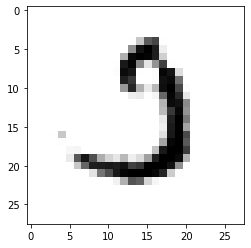

In [11]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray_r')

The ideas behind deep learning are simple, so why should their implementation be painful?